In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:

import os
import sys
import json

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [20]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [21]:
# where WellClass and Ga[ codes are located
sys.path.append('../src')

In [22]:
# WellClass
# from well_class_v2 import csv_parser, Well
from WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from WellClass.libs.well_class import Well
from WellClass.libs.well_pressure import Pressure

# plots
from WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [23]:
# use yaml or csv input file
use_yaml = True

In [24]:
# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [25]:
# where pvt located
pvt_path = '../test_data/pvt_constants/'

# Examples

The following are the test examples.

In [26]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
cosmo = {
         'well_input': r'GaP_input_Cosmo_v3.csv', 
         'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/cosmo', 
         'simcase': r'TEMP-0'}

In [27]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [28]:
# the selected example for testing
case = examples[case_type]


In [29]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [30]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [31]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

In [32]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
)

Hydrostatic pressure at reference depth 1217 is 120.43
RP1 set as hydrostatic P = 120.43 bar
RP2 is set as delta pressure, which yields P = 120.43 +20.00 = 140.43 bar
None ignored
Reference depth: 1217


# Visualization

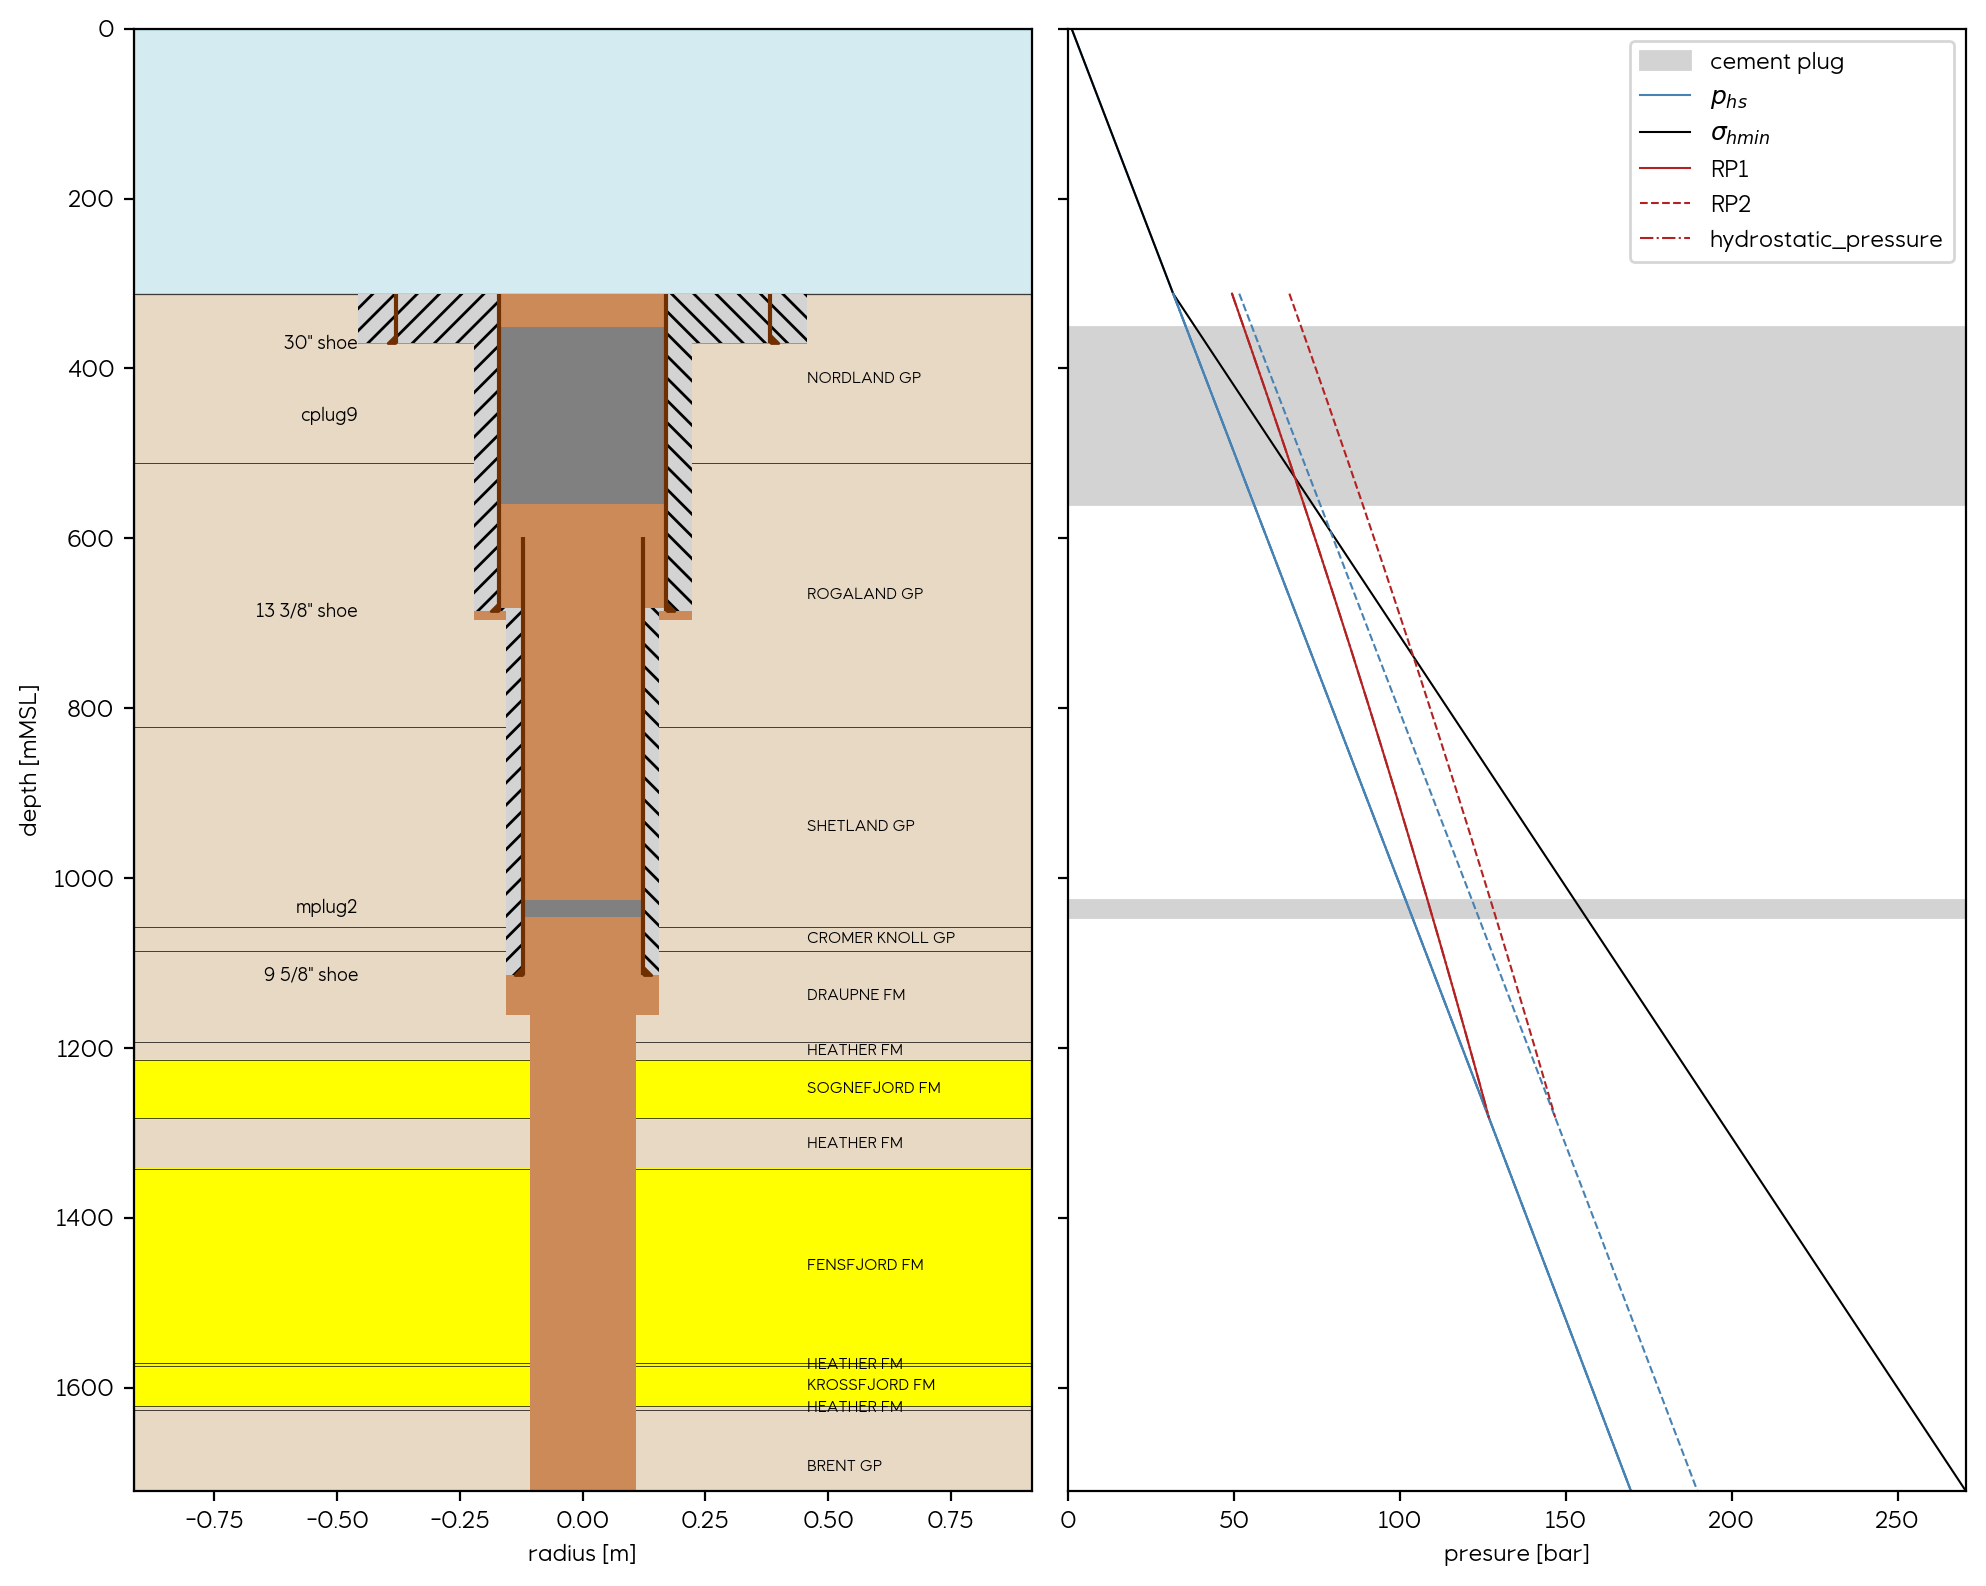

In [33]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2)

fig.tight_layout()

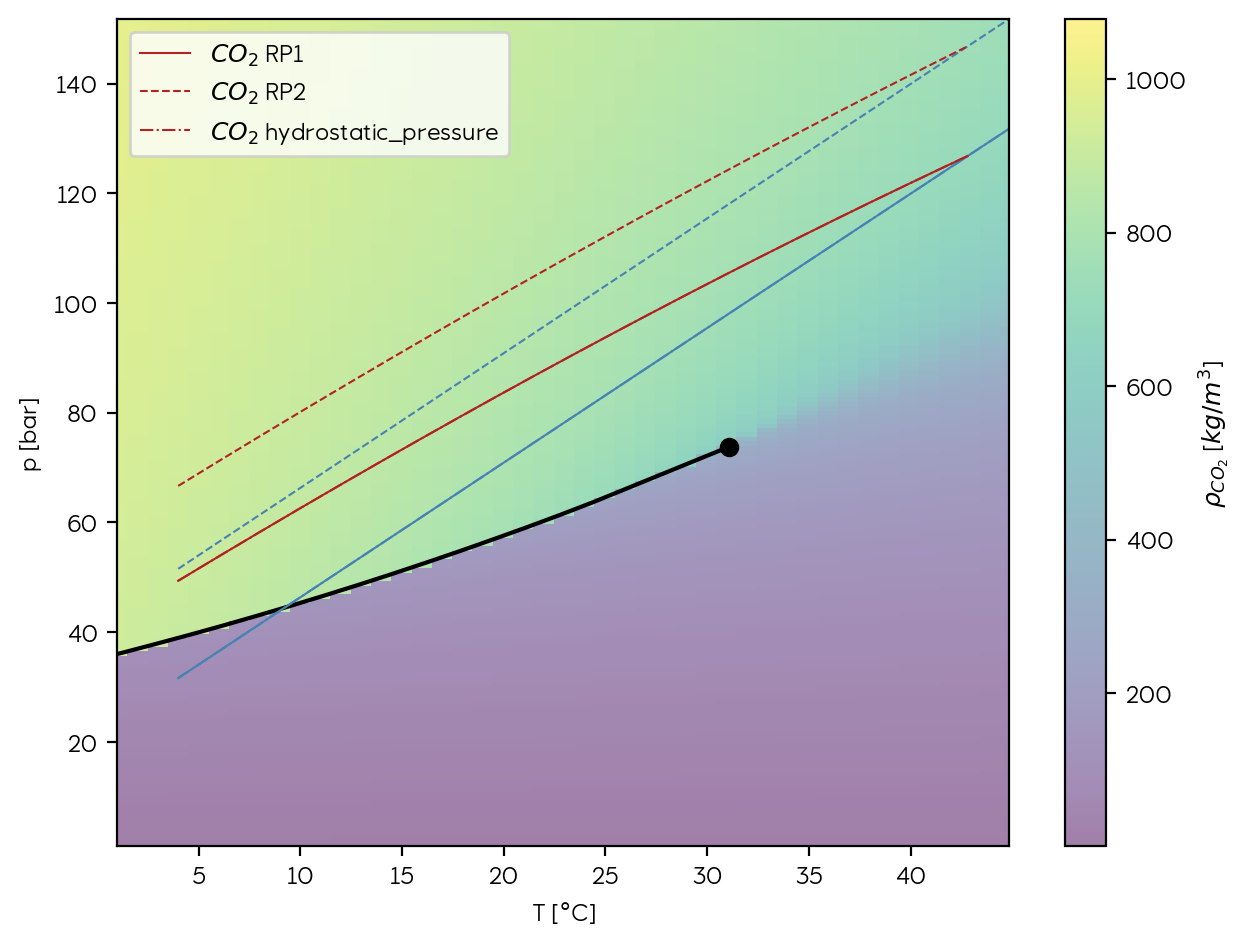

In [34]:
plot_pt(my_pressure)